Import statements

In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import numpy as np
from numpy.linalg import qr, solve, norm
from scipy.linalg import expm
from tqdm import tqdm

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Rosslermap class

In [3]:
class RosslerMap:
    """
    Rossler attractor
    With a=0.2, b=0.2, and c=5.7
    """

    def __init__(_, a=0.2, b=0.2, c=5.7, delta_t=1e-3):
        _.a, _.b, _.c = a, b, c
        _.delta_t = delta_t

    def v_eq(_, t=None, v=None):
        x, y, z = v[0], v[1], v[2]
        dot_x = -y - z
        dot_y = x + _.a*y
        dot_z = _.b + z*(x-_.c)
        return np.array([dot_x, dot_y, dot_z])

    def jacobian(_, v):
        x, z = v[0], v[2]
        res = np.array([[       0,      -1,       -1],
                       [        1,     _.a,        0],
                       [        z,       0,   x-_.c]])
        return res

    def full_traj(_, nb_steps, init_pos):
        t = np.linspace(0, nb_steps * _.delta_t, nb_steps)
        f = solve_ivp(_.v_eq, [0, nb_steps * _.delta_t], init_pos, method='RK45', t_eval=t)
        return np.moveaxis(f.y, -1, 0),t
    
    def equilibrium(_):
        x0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/2
        y0 = (-_.c+np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        z0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        return np.array([x0,y0,z0])


lyapunov exponent and newton functions

In [4]:
def lyapunov_exponent(traj, jacobian, max_it=1000, delta_t=1e-3):

    n = traj.shape[1]
    w = np.eye(n)
    rs = []
    chk = 0

    for i in range(max_it):
        jacob = jacobian(traj[i,:])
        #WARNING this is true for the jacobian of the continuous system!
        w_next = np.dot(expm(jacob * delta_t),w) 
        #if delta_t is small you can use:
        #w_next = np.dot(np.eye(n)+jacob * delta_t,w)
    
        w_next, r_next = qr(w_next)

        # qr computation from numpy allows negative values in the diagonal
        # Next three lines to have only positive values in the diagonal
        d = np.diag(np.sign(r_next.diagonal()))
        w_next = np.dot(w_next, d)
        r_next = np.dot(d, r_next.diagonal())

        rs.append(r_next)
        w = w_next
        if i//(max_it/100)>chk:
            print(i//(max_it/100))
            chk +=1
    
    return  np.mean(np.log(rs), axis=0) / delta_t

def newton(f,jacob,x):
    #newton raphson method
    tol =1
    while tol>1e-5:
        #WARNING this is true for the jacobian of the continuous system!
        tol = x
        x = x-solve(jacob(x),f(v=x))
        tol = norm(tol-x)
    return x

Experimenting 3 rossler map trajectories starting randomly from around the default initial point.

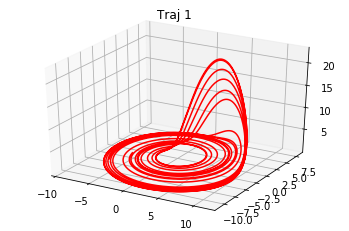

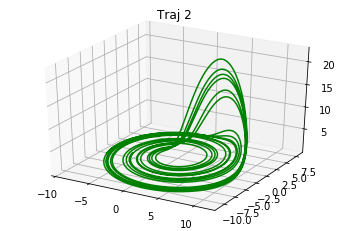

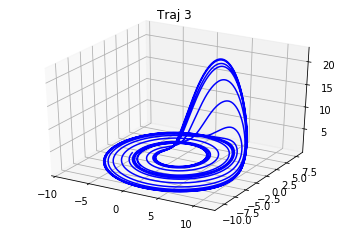

In [6]:
Niter = 10000
delta_t = 1e-2
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
INIT = np.array([-5.75, -1.6,  0.02])
traj,t = ROSSLER_MAP.full_traj(Niter, INIT)
[[x1,y1,z1],[x2,y2,z2],[x3,y3,z3]]= INIT + np.random.randn(3,3)/1000
traj1,t = ROSSLER_MAP.full_traj(Niter, np.array([x1,y1,z1]))
traj2,t = ROSSLER_MAP.full_traj(Niter, np.array([x2,y2,z2]))
traj3,t = ROSSLER_MAP.full_traj(Niter, np.array([x3,y3,z3]))

fig = plt.figure()
ax1 = fig.gca(projection='3d')
ax1.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'r')
plt.title("Traj 1")
plt.show() 

fig = plt.figure()
ax2 = fig.gca(projection='3d')
ax2.plot(traj2[:,0], traj2[:,1], traj2[:,2], 'g')
plt.title("Traj 2")
plt.show()

fig = plt.figure()
ax3 = fig.gca(projection='3d')
ax3.plot(traj3[:,0], traj3[:,1], traj3[:,2], 'b')
plt.title("Traj 3")
plt.show()

Rossler model

In [12]:
class Model(nn.Module):
    def __init__(self):
        """
        """
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 3)

    def forward(self, x):
        """
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [13]:
model = Model().to(device)

Training the rossler attractor model

The next cell is commented out. Uncomment it if you want to (re)train the model

In [14]:
def generate_data(k):
    "Generate k trajectories around the default initial point"
    ROSSLER_MAP = RosslerMap(delta_t=delta_t)
    init= INIT + np.random.randn(k,3)/1000
    traj,t = ROSSLER_MAP.full_traj(Niter, np.array(init[0]))
    input_traj = traj[:-1]
    output_traj = traj[1:]
    for i in tqdm(range(1,k)):
        traj,t = ROSSLER_MAP.full_traj(Niter, np.array(init[i]))
        input_traj = np.concatenate((input_traj,traj[:-1]), axis=0 )
        output_traj = np.concatenate((output_traj,traj[1:]), axis=0 )
    return(input_traj, output_traj)

input_traj, output_traj = generate_data(200)

In [17]:
N = len(input_traj)
indices = list(range(N))
valid_size = 0.2
valid_split = int(np.floor((valid_size) * N))

valid_idx, train_idx = indices[:valid_split], indices[valid_split:]
input_traj_train, output_traj_train = input_traj[train_idx], output_traj[train_idx]
input_traj_valid, output_traj_valid = input_traj[valid_idx], output_traj[valid_idx]
tensor_x, tensor_y  = torch.Tensor(input_traj_train), torch.Tensor(output_traj_train) # transform to torch tensor
tensor_x_valid, tensor_y_valid  = torch.Tensor(input_traj_valid), torch.Tensor(output_traj_valid)
dataset_train = data.TensorDataset(tensor_x,tensor_y) # create your datset
dataset_valid = data.TensorDataset(tensor_x_valid,tensor_y_valid) # create your datset
train_dataloader = data.DataLoader(dataset_train, shuffle=False, batch_size=Niter-1)
valid_dataloader = data.DataLoader(dataset_valid, shuffle=False, batch_size=Niter-1)

In [21]:

loss_fn = torch.nn.MSELoss(reduction='sum')
epochs= 5
error_train = list()
error_val = list()
best_model_path = 'model_trained_epoch0.pth'
torch.save(model.state_dict(), best_model_path)

best_val_error = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for t in tqdm(range(epochs)):
  # Forward pass: Compute predicted y by passing x to the model
    Loss = list()
    Loss_valid = list()  

    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        # Compute and print loss
        loss = loss_fn(y_pred, y)
        Loss.append(loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    error_train.append(np.mean(Loss))
    print( 'epoch', t, 'Training Loss',np.mean(Loss))
    with torch.no_grad():
        for x_,y_ in valid_dataloader:
            x_ , y_ = x_.to(device), y_.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            Loss_valid.append(loss.item())
        error_val.append(np.mean(Loss_valid))
        print( 'epoch', t, 'Validation_Loss',np.mean(Loss_valid)) 
    if np.mean(Loss_valid)< best_val_error:
        best_val_error = np.mean(Loss_valid)
        print("saving new model")
        best_model_path = 'trained_model-epoch{}.pth'.format( t)
        torch.save(model.state_dict(),best_model_path )


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0 Training Loss 43401.97726268768


 20%|██        | 1/5 [00:42<02:48, 42.05s/it]

epoch 0 Validation_Loss 357.9237976074219
epoch 1 Training Loss 259.04041080474855


 40%|████      | 2/5 [01:23<02:04, 41.50s/it]

epoch 1 Validation_Loss 172.19659423828125
epoch 2 Training Loss 140.7715491294861


 60%|██████    | 3/5 [02:04<01:23, 41.62s/it]

epoch 2 Validation_Loss 105.3821792602539
epoch 3 Training Loss 88.1009518146515


 80%|████████  | 4/5 [02:46<00:41, 41.73s/it]

epoch 3 Validation_Loss 69.82339477539062
saving new model
epoch 4 Training Loss 55.84099898338318


100%|██████████| 5/5 [03:27<00:00, 41.47s/it]

epoch 4 Validation_Loss 44.49980926513672
saving new model


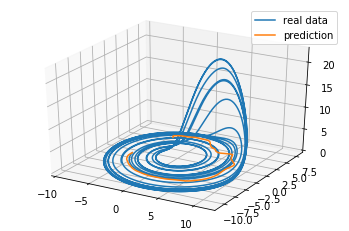

In [22]:
model.load_state_dict(torch.load(best_model_path))
[x0,y0,z0]= INIT + np.random.randn(3)/1000
test_traj,t_ = ROSSLER_MAP.full_traj(Niter, np.array([x0,y0,z0]))
pred_traj = np.zeros((len(test_traj),3))
w =[x0,y0,z0]
pred_traj[0] = w
for i in range(1, len(test_traj)):
    #print(np.linalg.norm(w - test_traj[i-1]))
    w = list(model(torch.Tensor(w).to(device)).detach().cpu().clone().numpy())
    pred_traj[i]= w
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(test_traj[:,0], test_traj[:,1], test_traj[:,2])
ax.plot(pred_traj[:,0], pred_traj[:,1], pred_traj[:,2])
plt.legend(['real data', 'prediction'])

In [23]:
best_model_path = 'model_trained.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

<All keys matched successfully>

In [26]:
from torchsummary import summary
summary(model, (1,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             256
            Linear-2               [-1, 1, 256]          16,640
            Linear-3               [-1, 1, 256]          65,792
            Linear-4                [-1, 1, 64]          16,448
            Linear-5                 [-1, 1, 3]             195
Total params: 99,331
Trainable params: 99,331
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


Testing the model

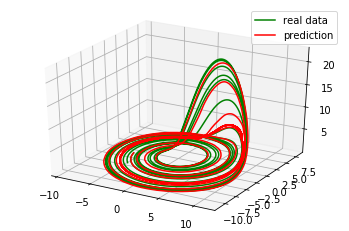

In [40]:
[x0,y0,z0] = INIT + np.random.randn(3)/1000
test_traj, t_ = ROSSLER_MAP.full_traj(Niter, np.array([x0,y0,z0]))
pred_traj = np.zeros((len(test_traj),3))
w = [x0,y0,z0]
pred_traj[0] = w
for i in range(1, len(pred_traj)):
    w = list(model(torch.Tensor(w).to(device)).detach().cpu().clone().numpy())
    pred_traj[i] = w
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(test_traj[:,0], test_traj[:,1], test_traj[:,2], 'g')
ax.plot(pred_traj[:,0], pred_traj[:,1], pred_traj[:,2], 'r')
plt.legend(['real data', 'prediction'])

## **Statistics**

- **Probability Distribution**


Text(0.5, 1.0, 'Probability Distribution of X')

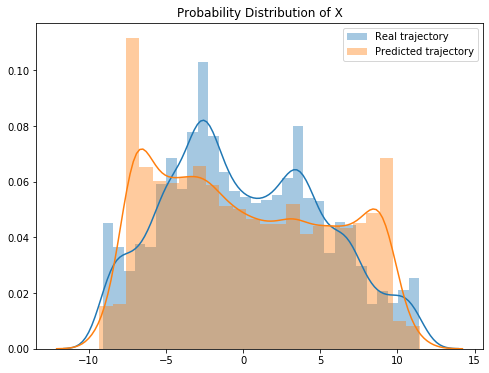

In [42]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.distplot(test_traj[:,0])
sns.distplot(pred_traj[:,0])
plt.legend(['Real trajectory', 'Predicted trajectory'])
plt.title('Probability Distribution of X')

Text(0.5, 1.0, 'Probability distribution of Y')

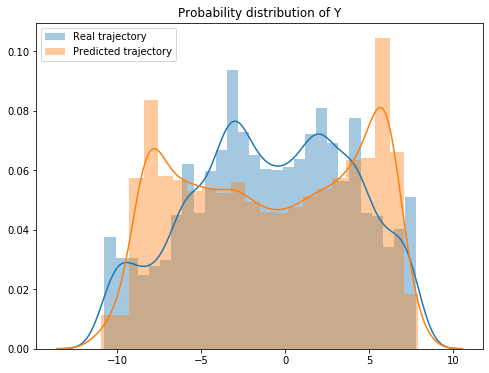

In [43]:
plt.figure(figsize=(8,6))
sns.distplot(test_traj[:,1])
sns.distplot(pred_traj[:,1])
plt.legend(['Real trajectory', 'Predicted trajectory'])
plt.title('Probability distribution of Y')

Text(0.5, 1.0, 'Probability Distribution  Z')

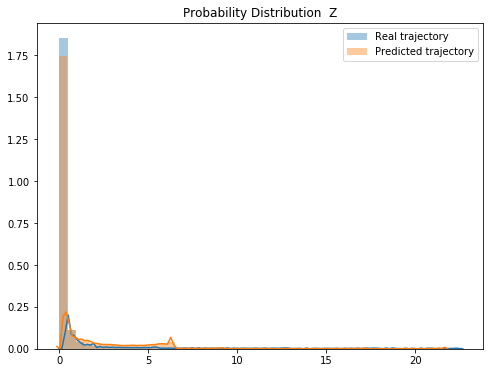

In [44]:
plt.figure(figsize=(8,6))
sns.distplot(test_traj[:,2])
sns.distplot(pred_traj[:,2])
plt.legend(['Real trajectory', 'Predicted trajectory'])
plt.title('Probability Distribution  Z')

- **Time correlations** : *Plot the autocorrelation function*


In [31]:
import statsmodels.api as sm

<Figure size 288x144 with 0 Axes>

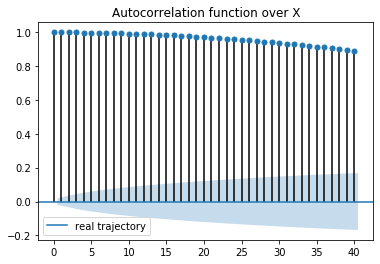

<Figure size 432x288 with 0 Axes>

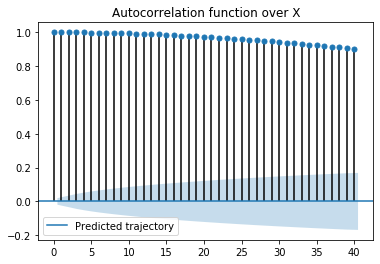

In [32]:
plt.figure(figsize=(4,2))
fig1 = plt.figure(1)
sm.graphics.tsa.plot_acf(test_traj[:,0])
plt.legend(['real trajectory'])
plt.title('Autocorrelation function over X')
plt.show()
fig2 = plt.figure(2)
sm.graphics.tsa.plot_acf(pred_traj[:,0])
plt.legend(['Predicted trajectory'])
plt.title('Autocorrelation function over X')
plt.show()

<Figure size 288x144 with 0 Axes>

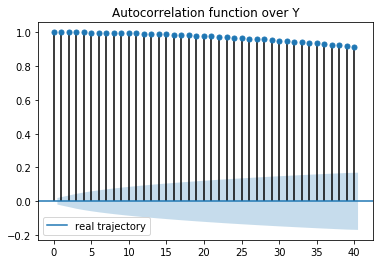

<Figure size 432x288 with 0 Axes>

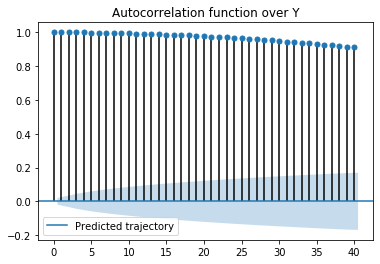

In [33]:
plt.figure(figsize=(4,2))
fig1 = plt.figure(1)
sm.graphics.tsa.plot_acf(test_traj[:,1])
plt.legend(['real trajectory'])
plt.title('Autocorrelation function over Y')
plt.show()
fig2 = plt.figure(2)
sm.graphics.tsa.plot_acf(pred_traj[:,1])
plt.legend(['Predicted trajectory'])
plt.title('Autocorrelation function over Y')
plt.show()

<Figure size 288x144 with 0 Axes>

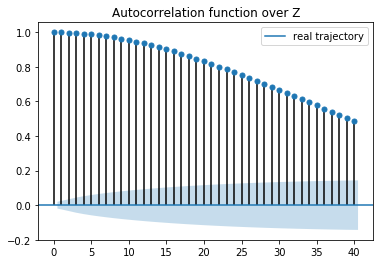

<Figure size 432x288 with 0 Axes>

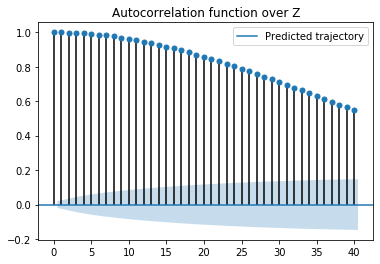

In [34]:
plt.figure(figsize=(4,2))
fig1 = plt.figure(1)
sm.graphics.tsa.plot_acf(test_traj[:,2])
plt.legend(['real trajectory'])
plt.title('Autocorrelation function over Z')
plt.show()
fig2 = plt.figure(2)
sm.graphics.tsa.plot_acf(pred_traj[:,2])
plt.legend(['Predicted trajectory'])
plt.title('Autocorrelation function over Z')
plt.show()

- **Fourier Coefficients**

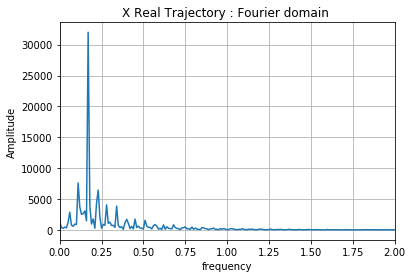

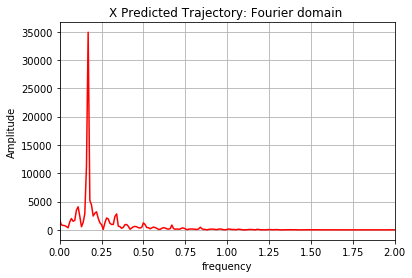

In [35]:
from scipy.fftpack import fft
yf = np.abs(fft(test_traj[:,0]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2])
plt.xlim(0, 2)
plt.grid()
plt.title('X Real Trajectory : Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

yf = np.abs(fft(pred_traj[:,0]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2], 'r')
plt.xlim(0, 2)
plt.grid()
plt.title('X Predicted Trajectory: Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

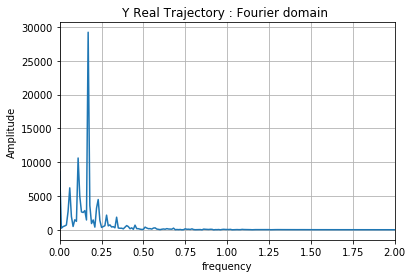

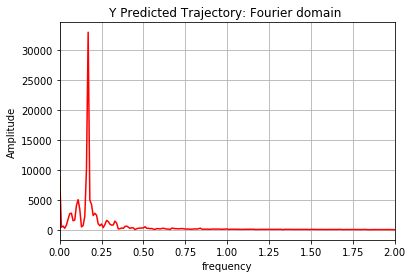

In [36]:
from scipy.fftpack import fft
yf = np.abs(fft(test_traj[:,1]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2])
plt.xlim(0, 2)
plt.grid()
plt.title('Y Real Trajectory : Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

yf = np.abs(fft(pred_traj[:,1]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2], 'r')
plt.xlim(0, 2)
plt.grid()
plt.title('Y Predicted Trajectory: Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

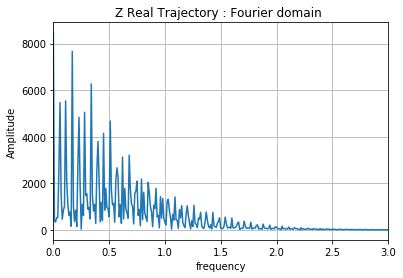

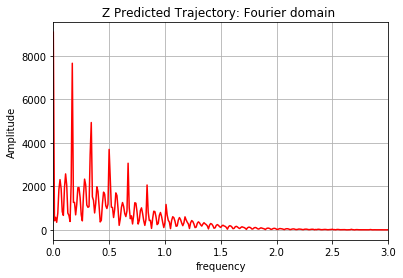

In [37]:
from scipy.fftpack import fft
yf = np.abs(fft(test_traj[:,2]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2])
plt.xlim(0, 3)
plt.grid()
plt.title('Z Real Trajectory : Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

yf = np.abs(fft(pred_traj[:,2]))
xf = np.array([k/Niter/delta_t for k in range(Niter//2)])
plt.plot(xf, yf[:Niter//2], 'r')
plt.xlim(0, 3)
plt.grid()
plt.title('Z Predicted Trajectory: Fourier domain ')
plt.xlabel('frequency')
plt.ylabel('Amplitude')
plt.show()

## **Physical Quantities**

- **Equilibrium**

In [38]:
def predict(v):
    [dot_x, dot_y, dot_z]= model(torch.Tensor(INIT).to(device)).detach().cpu().clone().numpy()
    return np.array([dot_x, dot_y, dot_z])

fix_point = newton(predict,ROSSLER_MAP.jacobian,INIT)

#error = norm(fix_point-ROSSLER_MAP.equilibrium())
#print("equilibrium state :", fix_point, ", error : ", error)

KeyboardInterrupt: 

- **Lyapunov_exponent**

In [ ]:
lyap = lyapunov_exponent(test_traj, ROSSLER_MAP.jacobian, max_it=Niter, delta_t=delta_t)
print("Lyapunov Exponents of the Real Trajectory :", lyap, "with delta t =", delta_t)

In [ ]:
lyap = lyapunov_exponent(pred_traj, ROSSLER_MAP.jacobian, max_it=Niter, delta_t=delta_t)
print("Lyapunov Exponents of the Predicted Trajectory :", lyap, "with delta t =", delta_t)